<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/ML%E5%9F%BA%E7%A1%80003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install toad

In [2]:
!pip install pandas_profiling

In [3]:
!pip install sweetviz

In [4]:
!pip install pydantic-settings

In [5]:
!wget https://raw.githubusercontent.com/wannasmile/colab_code_note/main/bank-full.csv

--2024-03-20 18:14:01--  https://raw.githubusercontent.com/wannasmile/colab_code_note/main/bank-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610348 (4.4M) [text/plain]
Saving to: ‘bank-full.csv.2’

bank-full.csv.2     100%[===================>]   4.40M  --.-KB/s    in 0.03s   

2024-03-20 18:14:01 (171 MB/s) - ‘bank-full.csv.2’ saved [4610348/4610348]



In [6]:
!wget -O simhei.ttf "https://raw.githubusercontent.com/wannasmile/colab_code_note/main/chinese.simhei.ttf"

--2024-03-20 18:14:01--  https://raw.githubusercontent.com/wannasmile/colab_code_note/main/chinese.simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octet-stream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  --.-KB/s    in 0.05s   

2024-03-20 18:14:01 (186 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



In [7]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split,cross_val_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve  # 导入指标库

from imblearn.over_sampling import SMOTE  # 过抽样处理库

import matplotlib.pyplot as plt
import prettytable  # 导入表格库

#from pandas_profiling import ProfileReport # 自动EDA
import sweetviz as sv # 自动EDA

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import os
import shutil
import toad
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from toad.plot import  bin_plot, badrate_plot
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from scipy.stats import scoreatpercentile
from toad.scorecard import ScoreCard

import matplotlib
matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')

%matplotlib inline
pd.set_option('display.max_columns', None)  # 显示所有列
# 风格设置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文
sns.set(style="ticks")  # 设置风格

In [8]:
# 导入相关库并且初始化设置
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve  # 导入指标库
import matplotlib.pyplot as plt
import prettytable  # 导入表格库
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import toad
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
# 风格设置
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文
sns.set(style="ticks") # 设置风格


# ---------------------------------------------------------变量处理---------------------------------------------------------

# 变量类型判定
def var_class(df, target, date_col=None, ncount=10):
    '''
    获取变量的类型

    df:数据表
    target:y变量
    date_col:日期变量，不提供则自动判断
    ncount:分类变量的取值数，默认<=10
    '''
    df1 = df.drop(target, axis=1)
    df2 = df1.apply(pd.to_numeric, errors='ignore') # 把能转换成数字的都转换成数字，不能转化的由error=True参数控制忽略掉。
    df3 = df2.select_dtypes(object).apply(pd.to_datetime, errors='ignore') # 此处注意，要把先选出object类别数据，毕竟pd.to_datetime()也可以将阿拉伯数字变成时间格式。

    dic_init={}
    # 筛选y变量
    dic_init[target]='y'
    # 筛选日期变量
    date_col = date_col
    if date_col:
        for d in date_col:
            dic_init[d]='date'
    else:
        for i,v in df3.dtypes.items():
            if v=='datetime64[ns]':
                dic_init[i]='date'
    # 筛选连续变量
    for i in df2.select_dtypes(include='number').columns:
        if df2[i].nunique()>ncount:
            dic_init[i]='number'

    # 筛选分类变量
    sur_col=[x for x in df.columns if x not in dic_init.keys()]
    dic_init.update(dict(zip(sur_col,['object']*len(sur_col))))

    return dic_init

# 获取各类型变量
def get_key(dic, value):
    '''
    获取特定值的键
    dic:字典
    value:特定值
    '''
    return list(filter(lambda k:dic[k] == value, dic))

# 字符串类型变量标签化
def obj_label(df, ex_lis=[]):
    '''
    df:数据集
    ex_lis:不需要标签化的列list
    '''
    df=df.copy()
    x_obj = [x for x in df.select_dtypes(object).columns if x not in ex_lis]
    df[x_obj] = df[x_obj].astype('str')
    dl = defaultdict(LabelEncoder)
    df[x_obj]=df[x_obj].apply(lambda x: dl[x.name].fit_transform(x))

    return df

# 连续变量分箱
def number_col_bins(df, nums_col, y, method='chi'):
    '''
    df:数据集
    nums_col:连续变量list
    y:y变量
    method:分箱方式

    return:分箱后的df
    '''
    df=df[nums_col+[y]].copy()
    # 连续变量分箱
    combiner = toad.transform.Combiner()
    combiner.fit(df, df[y], method=method, # 卡方分箱
                    min_samples=0.05)
    # 导出箱的节点
    vars_bins = combiner.export()
    # 分箱
    for x in nums_col:
        xmax=df[x].max()
        var_bins = []
        var_bins.append(float('-inf'))
        var_bins.extend(vars_bins[x])
        var_bins.append(xmax)
        df[x]=pd.cut(df[x], bins=var_bins, labels=var_bins[1:])
    return df

# 单变量eda
def var_eda(df, x, y, fonts=12):
    '''
    df:数据集
    x:变量x
    y:变量y
    object_col:分类变量列表
    '''

    #第一个图，柱状图
    ax1 = sns.countplot(x=x, data = df, color=sns.xkcd_rgb['windows blue'])
    ax1.set_xlabel(x, fontsize=fonts)
    ax1.set_ylabel(None)
    # sns.despine(ax=ax1) # 剔除右上边框
    #第二个图，点线图
    ax2 = ax1.twinx() # 共享x轴
    ax2 = sns.pointplot(x=x, y=y, data = df, ci=None, color=sns.xkcd_rgb['orangeish'])
    ax2.set_ylabel(None)
    ax2.set(ylim=(0,min(ax2.get_ylim()[1]+0.05,1)))
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0)) # 将纵坐标格式转化为百分比形式
    return plt

# 遍历列表所有元素
def iter_all(l, li):
    '''
    l:列表
    li:初始列表
    '''
    from collections import Iterable
    for i in l:
        if isinstance(i, Iterable):
            #当前元素为列表，继续调用
            iter_all(i, li)
        else:
            li.append(i)

# 多变量eda
def var_cross_eda(x, y, df, col, row=None, hue=None):
    '''
    x:变量X
    y:目标变量
    df:数据集
    col:按列的拆分
    row:按行的拆分
    hue:不同类别
    '''
    import warnings
    warnings.filterwarnings("ignore")

    # 设置双轴
    def twin_pointplot(**kwargs):
        ax = plt.twinx()
        sns.pointplot(**kwargs, ax=ax)
        ax.set_ylabel(None)
        ax.set(ylim=(0,min(ax.get_ylim()[1]+0.05,1)))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0)) # 将纵坐标格式转化为百分比形式
    # 分割图
    g = sns.FacetGrid(df, col=col, row=row, height=5, aspect=1.25)
    # 第1个柱状图
    g.map(sns.countplot, x=x, data=df, color=sns.xkcd_rgb['windows blue'])
    # 第2个点图
    g.map(twin_pointplot, x=x, y=y, hue=hue, color=sns.xkcd_rgb['orangeish'],
          data=df, ci=None)
    g.add_legend()
    # 获取每个分割图的ax
#     axs = g.axes
#     ax_list=[]
#     iter_all(axs, ax_list)
#     # 修改每个分割图信息
#     for ax in ax_list:
#         ax.set_xlabel(x, fontsize=14)
    g.set_xlabels(x, fontsize=14)
    return plt.show()

# ---------------------------------------------------------模型评估---------------------------------------------------------

# 模型评估指标-混淆矩阵
def model_confusion_metrics(model, X, y, name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    name:样本名称，默认为test
    '''
    # 混淆矩阵
    pre_y = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, pre_y).ravel() # 获得混淆矩阵
    confusion_matrix_table = prettytable.PrettyTable(['','prediction-0','prediction-1']) # 创建表格实例
    confusion_matrix_table.add_row(['actual-0',tp,fn]) # 增加第一行数据
    confusion_matrix_table.add_row(['actual-1',fp,tn]) # 增加第二行数据
    print(f'confusion matrix for {name}\n',confusion_matrix_table)

# 模型评估指标-核心指标
def model_core_metrics(model, X, y, name='test'):
    '''
    model:训练的模型对象名
    X:数据集
    y:标签集
    sample:样本名称，默认为test
    '''
    # 核心评估指标
    pre_y = model.predict(X)
    y_prob = model.predict_proba(X) # 获得决策树的预测概率，返回各标签的概率
    fpr, tpr, thres = roc_curve(y, y_prob[:, 1]) # ROC y_score[:, 1]取标签为1的概率，这样画出来的roc曲线为正
    auc_s = auc(fpr, tpr) # AUC
    ks = max(tpr - fpr) # KS值
    scores = [i(y, pre_y) for i in (accuracy_score,precision_score,\
                                         recall_score,f1_score)] # accuracy、precision、recall、f1
    scores.insert(0,auc_s)
    scores.append(ks)
    core_metrics = prettytable.PrettyTable() # 创建表格实例
    core_metrics.field_names = ['auc', 'accuracy', 'precision', 'recall', 'f1', 'ks'] # 定义表格列名
    core_metrics.add_row([round(i, 3) for i in scores]) # 增加数据
    print(f'core metrics for {name}\n',core_metrics)

# ---------------------------------------------------------指标绘图---------------------------------------------------------

# 模型区分排序能力
# ROC曲线
def plot_roc(model, X, y, name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    name:样本名称，默认为test

    return:返回roc曲线
    '''
    # 预处理
    y_prob = model.predict_proba(X)
    fpr, tpr, thres = roc_curve(y, y_prob[:, 1])
    # 绘图
    plt.plot(fpr, tpr, label=name) # 通过plot()函数绘制折线图
    plt.plot([0,1],[0,1],'r--')
    plt.title('ROC Curve for')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='best')
    return plt

# KS曲线
def plot_ks(model, X, y, name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    name:样本名称，默认为test

    return:返回ks曲线
    '''
    # 预处理
    y_prob = model.predict_proba(X)
    fpr, tpr, thres = roc_curve(y, y_prob[:, 1])
    # 绘图
    plt.title(f'KS Curve for {name}')
    plt.plot(thres[1:], tpr[1:], label='tpr')
    plt.plot(thres[1:], fpr[1:], label='fpr')
    plt.plot(thres[1:], tpr[1:] - fpr[1:], label='tpr-fpr')
    plt.xlabel('threshold')
    plt.gca().invert_xaxis()
    plt.legend(loc='best')
    return plt

# PR曲线
def plot_pr(model, X, y, name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    name:样本名称，默认为test

    return:返回pr曲线
    '''
    # 预处理
    y_prob = model.predict_proba(X)
    precision, recall, _ = precision_recall_curve(y, y_prob[:, 1])
    # 绘图
    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(recall,precision,label=name)
    plt.legend(loc='best')
    return plt

# Lift曲线
def plot_lift(model, X, y, bins=10, name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    name:样本名称，默认为test

    return:返回lift曲线
    '''
    # 预处理
    y_prob = model.predict_proba(X)[:, 1]
    df=toad.metrics.KS_bucket(y_prob, y,
                           bucket=bins,
                           method='quantile')

    df_temp = df[['bads', 'goods', 'total']].sort_index(ascending=False).reset_index(drop=True)
    bad_total = df['bads'].sum()
    good_total = df['goods'].sum()
    all_total = bad_total + good_total
    df_temp['bad_prop']=df_temp['bads'] / bad_total
    df_temp['total_prop']=df_temp['total'] / all_total
    df_temp['cum_bads']=df_temp['bads'].cumsum()
    df_temp['cum_bad_prop']=df_temp['cum_bads'] / bad_total
    df_temp['cum_total']=df_temp['total'].cumsum()
    df_temp['cum_total_prop']=df_temp['cum_total'] / all_total
    df_temp['lift']=df_temp['bad_prop'] / df_temp['total_prop']
    df_temp['cum_lift']=df_temp['cum_bad_prop'] / df_temp['cum_total_prop']

    df_finall=df_temp[['lift', 'cum_lift']]
    random_capture=1/df_finall.shape[0]

    # 提升图
    plt.title(f'Lift Table and Cruve for {name}')
    bar_width= 0.3
    plt.bar(np.arange(df_finall.shape[0])+1,df_finall['lift'],width=bar_width,color='hotpink',label='lift')
    plt.bar(np.arange(df_finall.shape[0])+1+bar_width,random_capture,width=bar_width,color='seagreen',label='random')
    plt.xticks(np.arange(df_finall.shape[0])+1)
    plt.plot(np.arange(df_finall.shape[0])+1,df_finall['cum_lift'],'r',label='cum_lift')
    plt.xticks(np.arange(df_finall.shape[0])+1)
    plt.legend(loc='best')

# 模型泛化能力
# cv箱线图
def plot_cv_box(model, X, y, fold=5, scoring='roc_auc', name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    fold:折数，默认为5
    scoring:评价分数，默认为auc
    name:样本名称，默认为test

    return:返回交叉验证箱线图
    '''
    # 预处理
    cv_result = cross_val_score(estimator=model,X=X,y=y,cv=fold,n_jobs=-1,scoring=scoring)
    # 绘图
    plt.title(f'cv box for {name}')
    plt.boxplot(cv_result,patch_artist=True,showmeans=True,
    boxprops={'color':'black','facecolor':'yellow'},
    meanprops={'marker':'D','markerfacecolor':'tomato'},
    flierprops={'marker':'o','markerfacecolor':'red','color':'black'},
    medianprops={'linestyle':'--','color':'orange'})
    return plt

# 学习曲线
def plot_learning_curve(model, X, y, n_splits=20, name='test'):
    '''
    model:训练的模型对象名
    X:X数据集
    y:y标签集
    n_splits:默认为20等份
    name:样本名称，默认为test

    return:返回学习曲线
    '''
    # 预处理
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    estimator = model
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # 绘图
    plt.title(f'Learning Curve for {name}')
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid()
    return plt

# 模型稳定性
def model_psi(model, X1, X2):
    '''
    model:训练的模型对象名
    X1:X1数据集
    X2:X2数据集
    return:模型psi
    '''
    prob1 = model.predict_proba(X1)[:, 1]
    prob2 = model.predict_proba(X2)[:, 1]
    model_psi = toad.metrics.PSI(prob1,prob2)
    return model_psi

# 模型捕获率报告
def capture_table(y_prob, y, bins=20):
    '''
    y_prob:概率
    y:真实值
    bins:等分箱数，默认为20

    return:模型捕获率报告
    '''
    df=toad.metrics.KS_bucket(y_prob, y,
                       bucket=bins,
                       method='quantile')
    df_temp = df[['bads', 'goods', 'bad_rate']].sort_index(ascending=False).reset_index(drop=True)
    df_temp['cum_bads']=df_temp['bads'].cumsum()
    df_temp['cum_goods']=df_temp['goods'].cumsum()
    df_temp['bads_total']=df_temp['bads'].sum()
    df_temp['goods_total']=df_temp['goods'].sum()
    df_temp['ks']=round(df_temp['cum_bads']/df_temp['bads_total'].map(lambda x:math.fabs(x))\
                           -df_temp['cum_goods']/df_temp['goods_total'],3)
    df_temp['cum_bads_prop']=df_temp['cum_bads'] / df_temp['bads_total']

    df_finall=df_temp[['ks', 'bads', 'goods', 'cum_bads', 'cum_goods', 'cum_bads_prop', 'bad_rate']]
    return df_finall

# 特征重要性排序
def feature_topN(model, X, n=10):

    # 预处理
    features = X.columns # 获取特征名称
    importances = model.feature_importances_  # 获取特征重要性
    feature_topN = pd.Series(importances, index=features).sort_values(ascending=False)[:n]
    feature_topN.sort_values(inplace=True)

    # 绘图
    plt.barh(feature_topN.index, feature_topN.values, height=0.7)
    plt.xlabel('importance') # x轴
    plt.ylabel('features') # y轴
    plt.title('Feature Importance') # 标题
    for a,b in zip( feature_topN.values,feature_topN.index): # 添加数字标签
       plt.text(a+0.00005, b,'%.3f'%float(a)) # a+0.001代表标签位置在柱形图上方0.001处
    return plt


# ---------------------------------------------------------评分卡绘图---------------------------------------------------------

# 评分直方图
def plot_score_hist(df, y_col, score_col, cutoff=None):
    """
    df:数据集（含y_col、score列）
    y_col:目标变量的字段名
    score_col:得分的字段名
    cutoff:划分拒绝/通过的点

    return:好坏用户的得分分布图
    """
    # 预处理
    x1 = df[df[y_col]==1][score_col]
    x2 = df[df[y_col]==0][score_col]
    # 绘图
    plt.title('Score_hist')
    sns.kdeplot(x1,shade=True,label='bad',color='hotpink')
    sns.kdeplot(x2,shade=True,label='good',color ='seagreen')
    if cutoff!=None:
        plt.axvline(x=cutoff)
    plt.legend()
    return plt

# 评分洛伦兹曲线
def plot_lorenz(df, y_col, score_col, bins=10, cutoff=None, name=''):
    '''
    df:数据集（含y_col、score列）
    y_col:目标变量的字段名
    score_col:得分的字段名
    bins:等分箱
    cutoff:划分拒绝/通过的点

    return:好坏用户的得分分布图
    '''
    score_list = list(df[score_col])
    label_list = list(df[y_col])
    items = sorted(zip(score_list,label_list),key = lambda x:x[0])
    step = round(df.shape[0]/bins,0)
    bad = df[y_col].sum()
    all_badrate = float(1/bins)
    all_badrate_list = [all_badrate]*bins
    all_badrate_cum = list(np.cumsum(all_badrate_list))
    all_badrate_cum.insert(0,0)

    score_bin_list=[]
    bad_rate_list = []
    for i in range(0,bins,1):
        index_a = int(i*step)
        index_b = int((i+1)*step)
        score = [x[0] for x in items[index_a:index_b]]
        tup1 = (min(score),)
        tup2 = (max(score),)
        score_bin = tup1+tup2
        score_bin_list.append(score_bin)
        label_bin = [x[1] for x in items[index_a:index_b]]
        bin_bad = sum(label_bin)
        bin_bad_rate = bin_bad/bad
        bad_rate_list.append(bin_bad_rate)
    bad_rate_cumsum = list(np.cumsum(bad_rate_list))
    bad_rate_cumsum.insert(0,0)
    y3 = bad_rate_cumsum
    y4 = all_badrate_cum

    plt.title('Lorenz curve')
    plt.plot(y3,color='hotpink',label='cun_bad_rate')
    plt.plot(y4,color='seagreen')
    plt.xticks(np.arange(bins+1),rotation=0)
    if cutoff!=None:
        plt.axvline(x=cutoff)
    plt.legend(loc='best')

# 寻找最优cutoff
def search_cutoff(df, y_col, score_col):
    '''
    df:数据集（含y_col、score列）
    y_col:目标变量的字段名
    score_col:得分的字段名
    return:最大ks及对应的score
    '''
    score_min=int(math.floor(df[score_col].min()))
    score_max=int(math.ceil(df[score_col].max()))

    cutoff = list(range(score_min, score_max))
    refuse_acc=[]
    tpr_ls=[]
    fpr_ls=[]
    KS_ls=[]
    for i in cutoff:
        df['result'] = df.apply(lambda x:'拒绝' if x[score_col]<=i else '接受',axis=1)
        TP = df[(df['result']=='拒绝')&(df[y_col]==1)].shape[0]
        FN = df[(df['result']=='拒绝')&(df[y_col]==0)].shape[0]
        bad = df[df[y_col]==1].shape[0]
        good = df[df[y_col]==0].shape[0]
        refuse = df[df['result']=='拒绝'].shape[0]
        passed = df[df['result']==10].shape[0]
        tpr = round(TP/bad,3)
        fpr = round(FN/good,3)
        KS = abs(tpr-fpr)
        KS_ls.append(KS)

    maxid_KS = KS_ls.index(max(KS_ls))
    co4 = cutoff[maxid_KS]
    print('最大KS值:{}'.format(max(KS_ls)))
    print('KS最大的分数:{}'.format(co4))

    return max(KS_ls),co4

# 设定cutoff并衡量有效性
def rule_verify(df, y_col, score_col, cutoff):
    """
    df:数据集
    y_col:目标变量的字段名
    score_col:得分的字段名
    cutoff:划分拒绝/通过的点
    return:混淆矩阵
    """
    df['result'] = df.apply(lambda x:'拒绝' if x[score_col]<=cutoff else '接受',axis=1)
    TP = df[(df['result']=='拒绝')&(df[y_col]==1)].shape[0]
    FN = df[(df['result']=='拒绝')&(df[y_col]==0)].shape[0]
    bad = df[df[y_col]==1].shape[0]
    good = df[df[y_col]==0].shape[0]
    refuse = df[df['result']=='拒绝'].shape[0]
    passed = df[df['result']==10].shape[0]

    acc = round(TP/refuse,3)
    tpr = round(TP/bad,3)
    fpr = round(FN/good,3)
    pass_rate = round(refuse/df.shape[0],3)
    matrix_df = pd.pivot_table(df,index='result',columns=y_col,aggfunc={score_col:pd.Series.count},values=score_col)

    print('拒绝准确率:{}'.format(acc))
    print('查全率:{}'.format(tpr))
    print('误伤率:{}'.format(fpr))
    print('规则拒绝率:{}'.format(pass_rate))
    return matrix_df

In [9]:
# 读取数据
raw_data = pd.read_csv('bank-full.csv', sep=';')
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
raw_data.groupby(['y']).count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
y,,,,,,,,,,,,,,,,
no,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922,39922
yes,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289,5289


In [11]:
# 生成好坏定义列
# 1表示bad客户（即未购买），0表示good客户（即购买了）

def convert_to_binary(value):
    return 1 if value == 'yes' else 0

raw_data['target'] = raw_data['y'].apply(convert_to_binary)
raw_data.drop('y', axis=1, inplace=True)

In [12]:
raw_data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,0
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,0
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,0
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,0
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,0


In [13]:
raw_data['ID'] = range(1, len(raw_data) + 1)

In [14]:
raw_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'target', 'ID'],
      dtype='object')

In [15]:
# 定义id列
ids_col = ['ID']
# 定义排除的特征列：一般包括ID列、日期列、目标列
ex_lis = ['ID', 'target']
# 定义排除列不含y
ex_lis_noy = ['ID']
# 定义y列
y_col = 'target'

In [16]:
# 查看变量统计信息
toad.detector.detect(raw_data)

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
age,int64,45211,0.00%,77,40.93621,10.618762,18.0,23.0,29.0,39.0,48.0,56.0,71.0,95.0
job,object,45211,0.00%,12,blue-collar:21.53%,management:20.92%,technician:16.80%,admin.:11.44%,services:9.19%,entrepreneur:3.29%,unemployed:2.88%,housemaid:2.74%,student:2.07%,unknown:0.64%
marital,object,45211,0.00%,3,married:60.19%,single:28.29%,divorced:11.52%,None,None,None,None,married:60.19%,single:28.29%,divorced:11.52%
education,object,45211,0.00%,4,secondary:51.32%,tertiary:29.42%,primary:15.15%,unknown:4.11%,None,None,secondary:51.32%,tertiary:29.42%,primary:15.15%,unknown:4.11%
default,object,45211,0.00%,2,no:98.20%,yes:1.80%,None,None,None,None,None,None,no:98.20%,yes:1.80%
balance,int64,45211,0.00%,7168,1362.272058,3044.765829,-8019.0,-627.0,0.0,448.0,1428.0,3574.0,13164.9,102127.0
housing,object,45211,0.00%,2,yes:55.58%,no:44.42%,None,None,None,None,None,None,yes:55.58%,no:44.42%
loan,object,45211,0.00%,2,no:83.98%,yes:16.02%,None,None,None,None,None,None,no:83.98%,yes:16.02%
contact,object,45211,0.00%,3,cellular:64.77%,unknown:28.80%,telephone:6.43%,None,None,None,None,cellular:64.77%,unknown:28.80%,telephone:6.43%
day,int64,45211,0.00%,31,15.806419,8.322476,1.0,2.0,5.0,16.0,21.0,28.0,31.0,31.0


In [17]:
# 查看变量价值信息
toad.quality(raw_data.drop(ex_lis_noy, axis=1), y_col, iv_only=True)

,iv,gini,entropy,unique
duration,1.644107,NaN,NaN,1573.0
poutcome,0.514609,NaN,NaN,4.0
pdays,0.438307,NaN,NaN,559.0
month,0.436131,NaN,NaN,12.0
contact,0.300396,NaN,NaN,3.0
previous,0.229509,NaN,NaN,41.0
age,0.213689,NaN,NaN,77.0
housing,0.188681,NaN,NaN,2.0
job,0.155697,NaN,NaN,12.0
balance,0.125193,NaN,NaN,7168.0


In [18]:
# 数据审查
na_count = raw_data.isnull().any().sum()  # 缺失值样本量
n_samples, n_features = raw_data.shape  # 总样本量，总特征数
print('samples: {0} | features: {1} | na count: {2}'.format(n_samples, n_features, na_count))

samples: 45211 | features: 18 | na count: 0


In [19]:
# 样本拆分：训练样本、测试样本
train, test = train_test_split(
    raw_data, test_size=.3, random_state=0)

In [20]:
# 特征初筛：缺失率>0.7、IV<0.1（一般认为iv低于0.1的特征区分度较弱）、相关系数>0.7
train_s, drop_lst = toad.selection.select(train, train[y_col],
                                                 empty=0.7, iv=0.1,
                                                 corr=0.7,
                                                 return_drop=True,
                                                 exclude=ex_lis)
print("keep:", train_s.shape[1],
      "drop empty:", len(drop_lst['empty']),
      "drop iv:", len(drop_lst['iv']),
      "drop corr:", len(drop_lst['corr']))

keep: 13 drop empty: 0 drop iv: 5 drop corr: 0


In [21]:
# 变量分箱
# 卡方分箱
# 得到切分节点
combiner = toad.transform.Combiner()
combiner.fit(train_s, train_s[y_col], method='chi', min_samples=0.05, exclude=ex_lis)
# 导出箱的节点
bins = combiner.export()
# 变量分箱
train_t = combiner.transform(train_s)
test_t = combiner.transform(test[train_s.columns])
print(bins)

{'age': [], 'job': [['blue-collar'], ['housemaid', 'entrepreneur', 'services'], ['technician'], ['self-employed', 'admin.', 'management', 'unknown'], ['unemployed', 'retired', 'student']], 'balance': [-54, 94, 920, 1612], 'housing': [['yes'], ['no']], 'contact': [['unknown'], ['telephone'], ['cellular']], 'day': [5, 10, 17, 21, 28], 'month': [['may', 'jul', 'jun', 'nov', 'jan', 'aug'], ['feb', 'apr', 'oct', 'dec', 'sep', 'mar']], 'duration': [89, 130, 206, 365, 473, 614], 'pdays': [9, 204], 'previous': [1, 3], 'poutcome': [['unknown', 'failure', 'other', 'success']]}


In [22]:
# WOE编码
w = toad.transform.WOETransformer()
#对WOE的值进行转化，映射到原数据集上。
#对训练集用fit_transform，测试集用transform。
train_w = w.fit_transform(train_t, train_t[y_col], exclude=ex_lis)
test_w = w.transform(test_t[train_t.columns])
data = pd.concat([train_w, test_w])

In [23]:
# 二次筛选
# PSI筛选
np.seterr(divide='ignore', invalid='ignore') # 防止0/0产生的invalid value
psi_df = toad.metrics.PSI(train_w, test_w).sort_values()
psi_df.head(10)

age         0.000000e+00
poutcome    0.000000e+00
ID          0.000000e+00
previous    2.905983e-07
target      7.243337e-06
pdays       1.112010e-05
housing     1.358440e-05
balance     1.041775e-04
contact     1.388553e-04
month       1.686118e-04
dtype: float64

In [24]:
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index': 'feature', 0: 'psi'})
psi_df.head(10)

,feature,psi
0,age,0.000000e+00
1,poutcome,0.000000e+00
2,ID,0.000000e+00
3,previous,2.905983e-07
4,target,7.243337e-06
5,pdays,1.112010e-05
6,housing,1.358440e-05
7,balance,1.041775e-04
8,contact,1.388553e-04
9,month,1.686118e-04


In [25]:
col_keep = list(set(list(psi_df[psi_df.psi<0.02].feature)).union(set(ex_lis))) # 保留低psi特征和不参与特征的并集
train_psi = train_w[col_keep]

print("keep:", train_psi.shape[1])

keep: 13


In [26]:
# 因特征WOE编码后
# 部分变量的IV变低
# 且整体相关性变大
# 故再次做特征筛选
train_psi_s_, drop_lst = toad.selection.select(train_psi,
                                               train_psi[y_col],
                                               empty=0.7,
                                               iv=0.1,
                                               corr=0.7,
                                               return_drop=True,
                                               exclude=ex_lis)
print("keep:", train_psi_s_.shape[1],
      "drop empty:", len(drop_lst['empty']),
      "drop iv:", len(drop_lst['iv']),
      "drop corr:", len(drop_lst['corr']))

keep: 9 drop empty: 0 drop iv: 3 drop corr: 1


In [27]:
# 逐步回归筛选变量
train_stp = toad.selection.stepwise(train_psi_s_,
                                    train_psi_s_[y_col],
                                    exclude=ex_lis,
                                    direction='both',
                                    criterion='aic',
                                    estimator='ols',
                                    intercept=False)

print("keep:", train_stp.shape[1])

keep: 8


In [28]:
# 生成最终使用数据
test_stp = test_w[train_stp.columns]
data_final = pd.concat([train_stp, test_stp])
print(data_final.shape)

(45211, 8)


In [29]:
# 样本拆分
X, y = data_final.drop(ex_lis, axis=1), data_final[y_col]
X_train, y_train = train_stp.drop(ex_lis, axis=1), train_stp[y_col]
X_test, y_test = test_stp.drop(ex_lis, axis=1), test_stp[y_col]

In [30]:
# 模型训练
model_lr = LogisticRegression(C=0.1, class_weight='balanced')
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced')

In [31]:
# 核心指标评估
model_confusion_metrics(model_lr, X_test, y_test, 'test')
model_core_metrics(model_lr, X_test, y_test, 'test')

confusion matrix for test
 +----------+--------------+--------------+
|          | prediction-0 | prediction-1 |
+----------+--------------+--------------+
| actual-0 |     1310     |     285      |
| actual-1 |     2424     |     9545     |
+----------+--------------+--------------+
core metrics for test
 +------+----------+-----------+--------+-------+-------+
| auc  | accuracy | precision | recall |   f1  |   ks  |
+------+----------+-----------+--------+-------+-------+
| 0.88 |   0.8    |   0.351   | 0.821  | 0.492 | 0.624 |
+------+----------+-----------+--------+-------+-------+


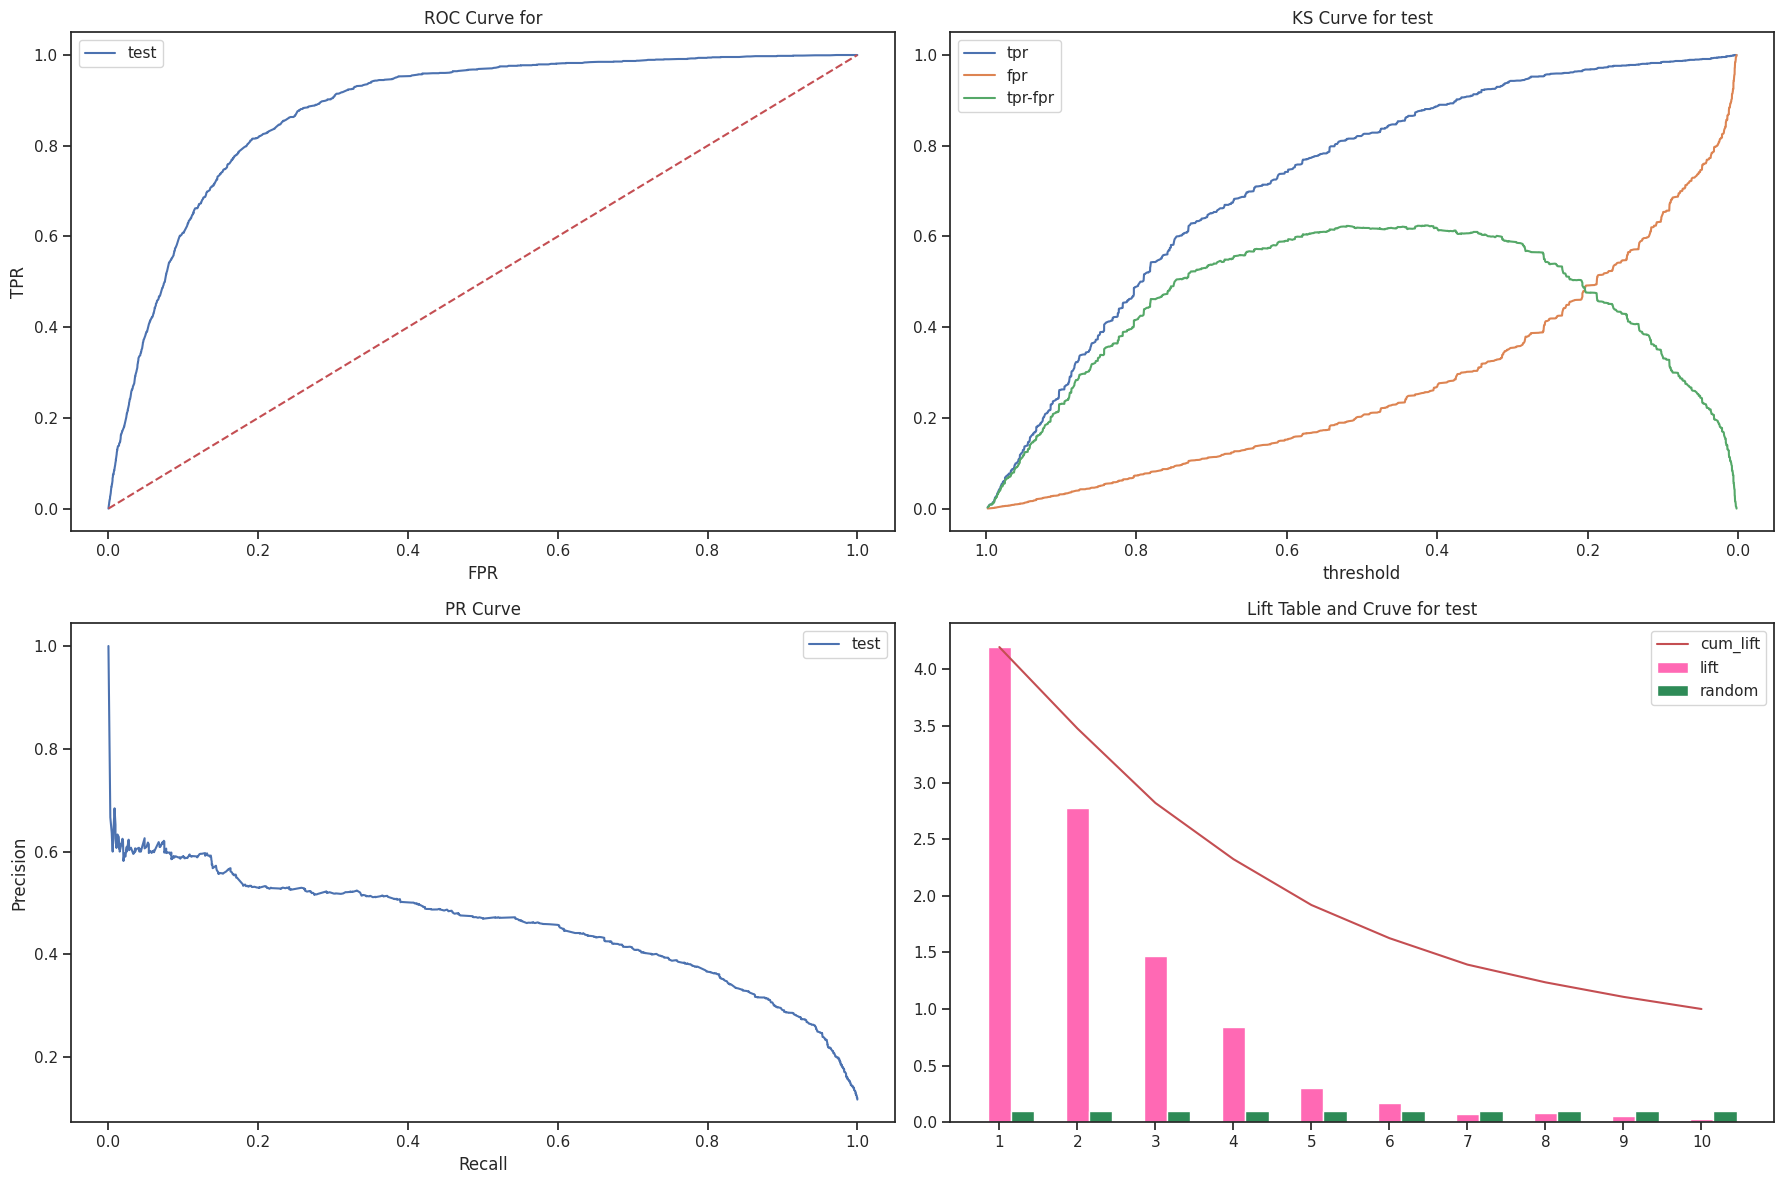

In [32]:
# 模型区分与排序能力 评估
fig = plt.figure(figsize=(18,12))
plt.subplot(221)
plot_roc(model_lr, X_test, y_test, name='test')
plt.subplot(222)
plot_ks(model_lr, X_test, y_test, name='test')
plt.subplot(223)
plot_pr(model_lr, X_test, y_test, name='test')
plt.subplot(224)
plot_lift(model_lr, X_test, y_test, name='test')
plt.tight_layout()
plt.show()

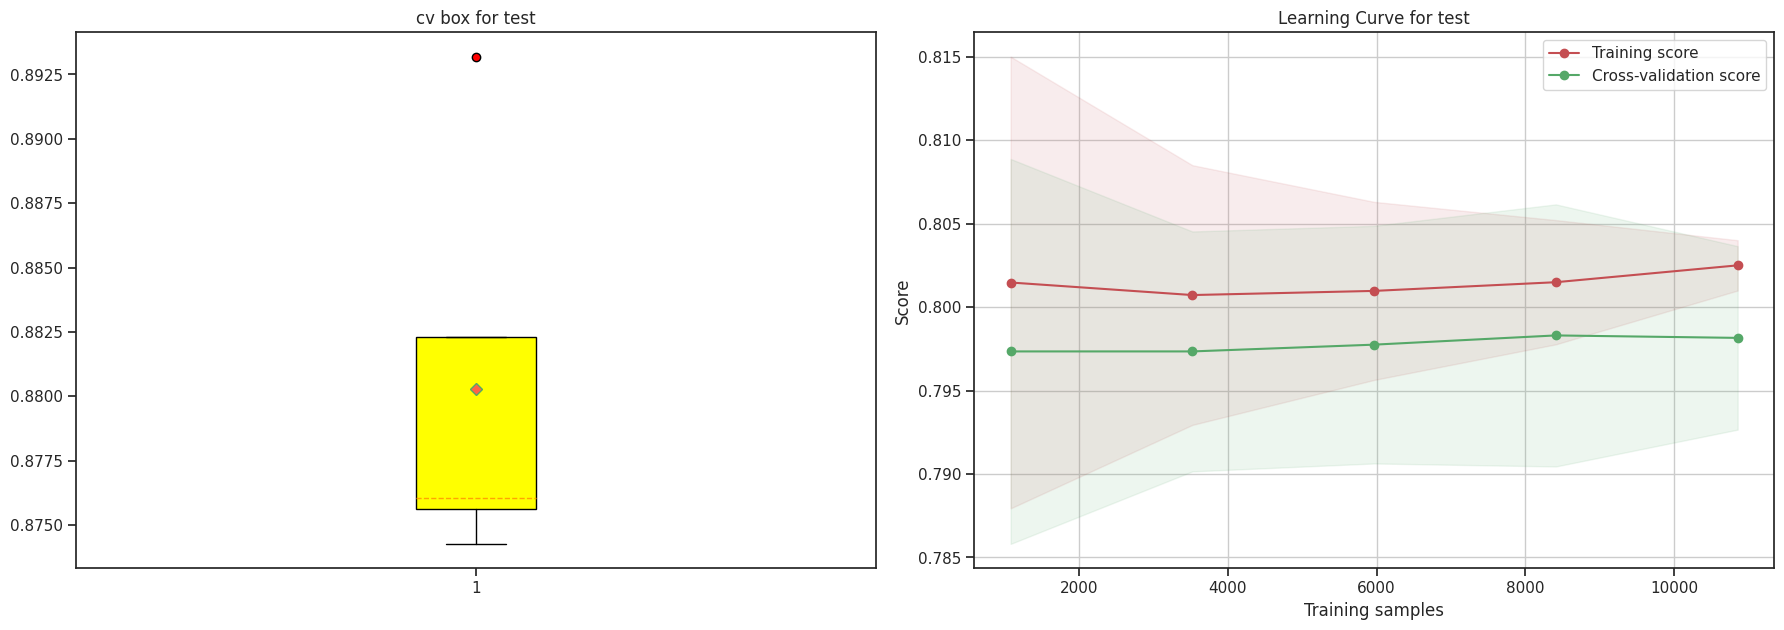

In [33]:
# 模型泛化能力评估
fig = plt.figure(figsize=(18,12))
plt.subplot(221)
plot_cv_box(model_lr, X_test, y_test, name='test')
plt.subplot(222)
plot_learning_curve(model_lr, X_test, y_test, name='test')
plt.tight_layout()
plt.show()

In [34]:
# 模型稳定性评估
# 模型PSI：小于10%，则无需更新模型
# 模型PSI：10%-20%，需检查变化原因，加强监控频率
# 模型PSI：大于20%，则模型需要迭代
mpsi = model_psi(model_lr, X_train, X_test)
print('模型PSI:', mpsi)

模型PSI: 0.12488127593633798


In [35]:
# 模型捕获报告评估
# 模型捕获率报告
y_test_prob = model_lr.predict_proba(X_test)[:, 1]
df_capture = capture_table(y_test_prob, y_test)
df_capture.columns=['KS', '负样本个数', '正样本个数', '负样本累计个数', '正样本累计个数', '捕获率', '负样本占比']
df_capture

,KS,负样本个数,正样本个数,负样本累计个数,正样本累计个数,捕获率,负样本占比
0,0.202,366,327,366,327,0.229467,0.528139
1,0.363,304,361,670,688,0.420063,0.457143
2,0.496,269,420,939,1108,0.588715,0.390421
3,0.567,181,511,1120,1619,0.702194,0.261561
4,0.615,151,552,1271,2171,0.796865,0.214794
5,0.619,78,549,1349,2720,0.845768,0.124402
6,0.612,71,608,1420,3328,0.890282,0.104566
7,0.600,63,617,1483,3945,0.929781,0.092647
8,0.567,33,647,1516,4592,0.950470,0.048529
9,0.521,15,664,1531,5256,0.959875,0.022091


In [36]:
# 结果展示
# 评分卡
# 计算odds
bad_total=raw_data[y_col].sum()
good_total=raw_data.shape[0]-bad_total
odds=round(bad_total/good_total,2)
base_odds=round(good_total/bad_total,0)
print('bad_total:{0}\ngood_total:{1}\nodds:{2}\nbase_odds:{3}\n'.format(bad_total,good_total,odds,base_odds))

bad_total:5289
good_total:39922
odds:0.13
base_odds:8.0



In [37]:
# 生成评分卡报告
# 注意ScoreCard方法里求解A=P0-B*log(odds)
# 因此这里的base_odds使用好坏比即(1-p)/p
card = ScoreCard(combiner=combiner,
                    transer=w, C=0.1,
                    class_weight='balanced',
                    base_score=600,
                    base_odds=1/8,
                    pdo=60,
                    rate=2)
card.fit(X_train, y_train)
# 输出标准评分卡
final_card = card.export(to_frame=True)
final_card

,name,value,score
0,housing,yes,175.09
1,housing,no,92.39
2,pdays,[-inf ~ 9),155.87
3,pdays,[9 ~ 204),13.95
4,pdays,[204 ~ inf),119.75
5,duration,[-inf ~ 89),468.23
6,duration,[89 ~ 130),290.43
7,duration,[130 ~ 206),194.89
8,duration,[206 ~ 365),122.96
9,duration,[365 ~ 473),75.06


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


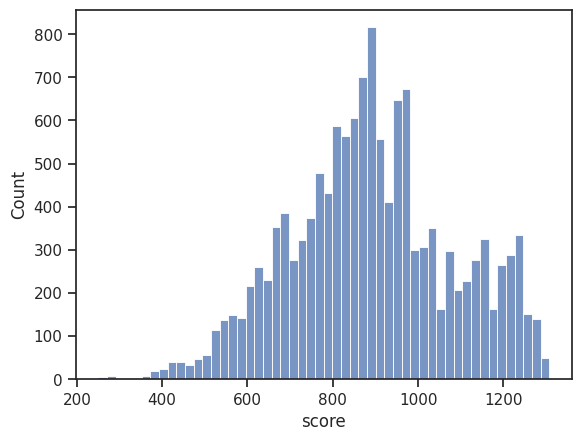

In [38]:
def get_score(X, card):
    '''
    X: X数据集
    card: 评分卡对象名

    return: 增加分值列的df
    '''
    df_score = pd.DataFrame(card.predict(X), index=X.index, columns=["score"])
    df_data_score = pd.concat([X,df_score], axis=1)
    return df_data_score

final_data_score=get_score(test, card)
# 得分的直方图
sns.histplot(final_data_score['score'])
plt.show()

<ipython-input-8-f199880d84dd>:474: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1,shade=True,label='bad',color='hotpink')
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-8-f199880d84dd>:475: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x2,shade=True,label='good',color ='seagreen')
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('m

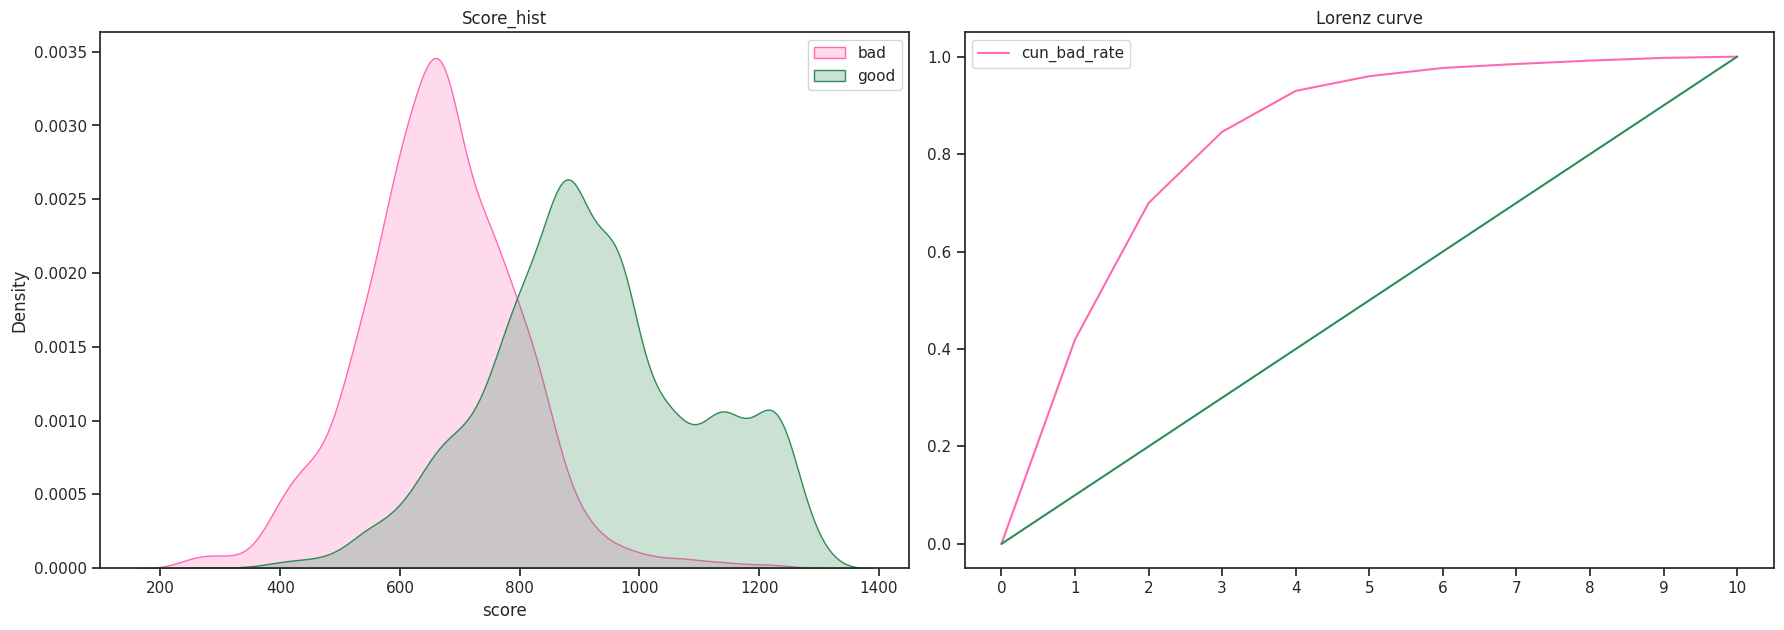

In [39]:
# 评分卡区分能力评估
fig = plt.figure(figsize=(18,12))
plt.subplot(221)
plot_score_hist(final_data_score, y_col, 'score')
plt.subplot(222)
plot_lorenz(final_data_score, y_col, 'score')
plt.tight_layout()
plt.show()

> 好坏客户的分布重合度较低，评分卡区分能力较好
>
> 洛伦兹曲线较平缓，区分能力一般

In [40]:
# 确定评分卡cutoff点
%%time

# 搜索cutoff点
print('{:*^60}'.format('cutoff search result'))
_, cutoff_score=search_cutoff(final_data_score,y_col,'score')
print('{:*^60}'.format('set cutoff result'))
# 设定cutoff点
# 衡量有效性
matrix_df=rule_verify(final_data_score,y_col,'score',cutoff_score)

********************cutoff search result********************
最大KS值:0.624
KS最大的分数:806
*********************set cutoff result**********************
拒绝准确率:0.316
查全率:0.876
误伤率:0.252
规则拒绝率:0.326
CPU times: user 1min 57s, sys: 281 ms, total: 1min 58s
Wall time: 2min 1s


<ipython-input-8-f199880d84dd>:474: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1,shade=True,label='bad',color='hotpink')
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-8-f199880d84dd>:475: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x2,shade=True,label='good',color ='seagreen')
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('m

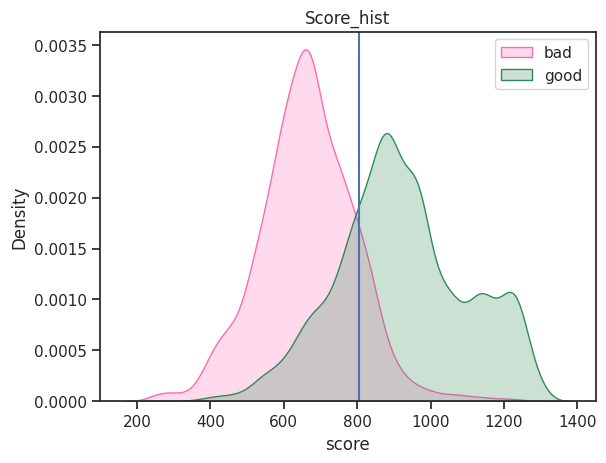

In [41]:
# 查看cutoff结果
plot_score_hist(final_data_score, y_col, 'score', cutoff=cutoff_score)
plt.show()

In [42]:
# 用户得分雷达图
# 生成评分明细
final_data_score_detail = card.predict(test, return_sub=True)[1]
final_data_score_detail['score'] = final_data_score_detail[list(final_card['name'].unique())].sum(axis=1)
# 归一化处理
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
final_data_score_detail_scaler = final_data_score_detail.copy()
final_data_score_detail_scaler.iloc[:,:-1] = final_data_score_detail_scaler.iloc[:,:-1].apply(max_min_scaler)

In [43]:
final_data_score_detail_scaler.head(10)

,housing,pdays,duration,month,job,balance,score
14001,1.0,1.000000,0.681644,1.0,0.505936,0.193026,1030.421277
32046,1.0,1.000000,0.000000,0.0,0.878456,1.000000,616.879845
13318,0.0,1.000000,0.381776,1.0,1.000000,1.000000,879.405686
42991,1.0,0.000000,0.681644,0.0,0.878456,0.299338,800.334185
14237,1.0,1.000000,0.381776,1.0,1.000000,1.000000,962.111680
14360,1.0,1.000000,0.681644,1.0,0.878456,1.000000,1120.855476
36635,1.0,1.000000,0.510565,1.0,1.000000,0.000000,955.106620
37042,1.0,0.745485,1.000000,1.0,1.000000,0.299338,1215.947906
25994,0.0,1.000000,0.510565,1.0,0.505936,0.299338,860.563615
14555,0.0,1.000000,1.000000,1.0,0.000000,1.000000,1152.886573


In [44]:
final_data_score_detail_scaler.loc[14360]

housing        1.000000
pdays          1.000000
duration       0.681644
month          1.000000
job            0.878456
balance        1.000000
score       1120.855476
Name: 14360, dtype: float64

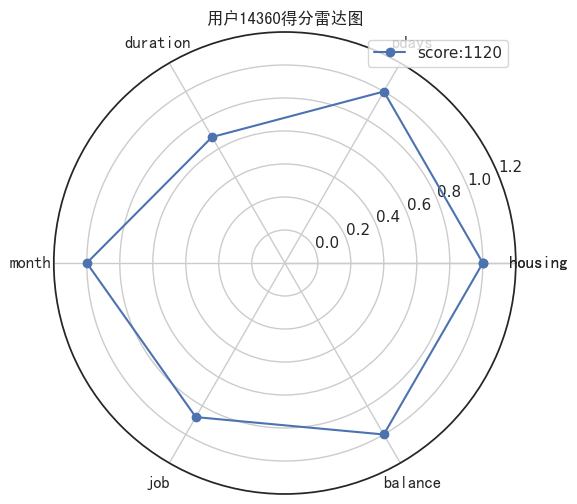

In [45]:
# 画布基本设置
fig = plt.figure(figsize=(6,6))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格（注意polar参数）
labels = final_card['name'].unique()  # 设置要展示的数据标签
cor_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels,[labels[0]]))  # 新版本增加对labels进行封闭

# 画雷达图
i = 14360
score = int(final_data_score_detail_scaler.loc[i]['score'])
data_tmp = np.array(final_data_score_detail_scaler.loc[i])[0:-1]  # 获得对应类数据
data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
ax.plot(angles, data, 'o-', c=cor_list[0], label=f'score:{score}')  # 画线
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")  # 设置极坐标轴
ax.set_title(f"用户{i}得分雷达图", fontproperties="SimHei")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc=0)  # 设置图例位置
plt.show()